# Tutorial: Single chromosome optimization using OpenMiChroM


## This tutorial performs optimization in the MiChroM Parameters (Second-order optimization -> Hessian inversion)

*The first step is to import the OpenMiChroM modules.*

To install OpenMM and OpenMiChroM, follow the [instalation guide](https://open-michrom.readthedocs.io/en/latest/#).

The inputs and apps used in this tutorial can be downloaded [here](https://github.com/junioreif/OpenMiChroM/tree/main/Tutorials/MiChroM_Optimization).

<font color='red'>Types optimization is available starting in the OpenMichroM version 1.1.0.</font> 

In [1]:
# OpenMiChroM simulation module
from OpenMiChroM.ChromDynamics import MiChroM
# Optimization of MiChroM parameters module
from OpenMiChroM.Optimization import CustomMiChroMTraining
# Analysis tools module
from OpenMiChroM.CndbTools import cndbTools

# Extra modules to load and plot .dense file 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import os
cndbTools = cndbTools()

*The second step is to have a look on the experimental Hi-C*

A Hi-C file is required for the analysis and training of the MiChroM Potentials (Types and Ideal Chromosome). The file format chosen here is a matrix .txt file (we call it the dense file).

For this tutorial, we will use chromosome 10 from GM12878 in 100 kb resolution. The file was downloaded from github MiChroM.

Visualize the .dense file.

Number of beads:  1356
Plot saved as 'result/hic_plot_exp.png'


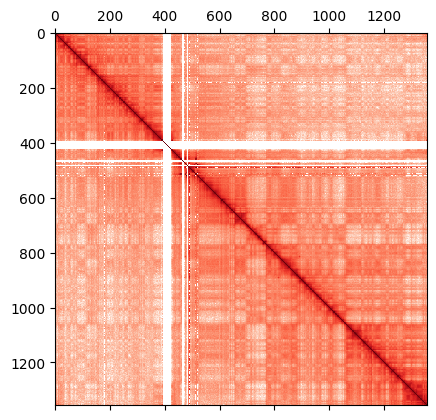

In [2]:
# Load the file
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r = np.triu(hic_file, k=1) 
r[np.isnan(r)] = 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r = r + rd + np.diag(np.ones(len(r)))

print("Number of beads: ", len(r))

# Create the plot
plt.matshow(r, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()), cmap="Reds")

# Creating the 'result' folder if it does not exist
output_dir = 'result'
os.makedirs(output_dir, exist_ok=True)

# Save the plot to a file
plt.savefig("result/hic_plot_exp.png", dpi=300, bbox_inches='tight')

print("Plot saved as 'result/hic_plot_exp.png'")

This Hi-C map has a resolution of 100 kb per bead, so the chromosome 10 model has a polymer chain with a total of 1356 beads.

The next step is to extract the sequence file containing the A/B compartments along the sequence by using the eigenvector decomposition. The file was downloaded from github MiChroM. <br>


For more details about how it works, please take a look on this paper: https://pubs.acs.org/doi/full/10.1021/acs.jpcb.1c04174

And visualize the .eigen file.

Processed matrix saved as TXT in: result/eigen_processed.txt
Chart saved as PNG in: result/eigen_processed.png


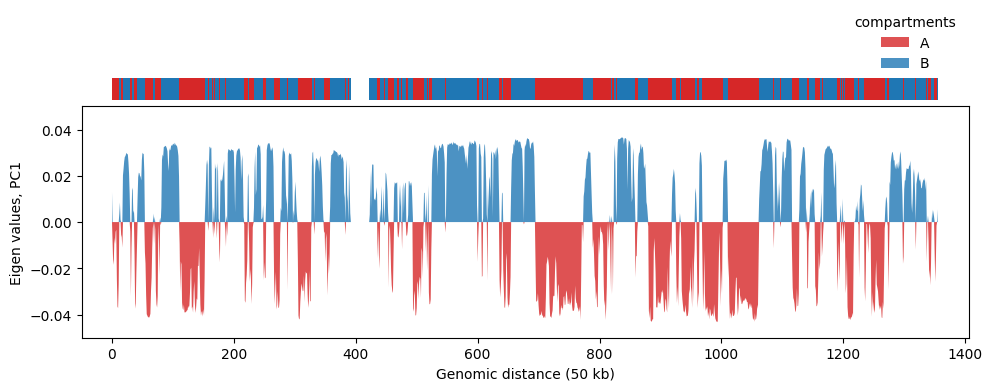

In [3]:
# Load the file
eigen = np.loadtxt("input/chr10_100k.eigen")

# Process the data
index = np.arange(eigen.size)
df = pd.Series(eigen, index=index)

A1_df = pd.Series(np.zeros(eigen.size), index=index) 
A1_df[df < 0] = df[df < 0]
B1_df = pd.Series(np.zeros(eigen.size), index=index) 
B1_df[df > 0] = df[df > 0]

# Save processed matrix to a TXT file
output_file_txt = 'result/eigen_processed.txt'
df.to_csv(output_file_txt, index=True, header=False)

# Generate graph and save as PNG
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(6.4 * 3 / 2, 4.8 * 2 / 3), gridspec_kw={'height_ratios': [1, 10]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

# Sequence
A11_df = A1_df.copy()
A11_df[A1_df < 0] = 1
B11_df = B1_df.copy()
B11_df[B1_df > 0] = 1

axes[0].axis('off')
width = 1
axes[0].bar(A11_df.index, A11_df, width, color="tab:red")
axes[0].bar(B11_df.index, B11_df, width, color="tab:blue")
axes[0].set_xlim([-50, eigen.size + 50])

# Eigen PC1
step = 1
axes[1].fill_between(A1_df.index[::step], A1_df[::step], 0, facecolor="tab:red", alpha=0.8, label="A")
axes[1].fill_between(B1_df.index[::step], B1_df[::step], 0, facecolor="tab:blue", alpha=0.8, label="B")

axes[1].set_ylim([-0.05, 0.05])
axes[1].set_xlim([-50, eigen.size + 50])
axes[1].set_ylabel('Eigen values, PC1')
axes[1].set_xlabel('Genomic distance (50 kb)')
axes[1].legend(title='compartments', bbox_to_anchor=(1., 1.45), frameon=False)

# Save image in the same format it appears in Jupyter Notebook
output_file_png = 'result/eigen_processed.png'
fig.savefig(output_file_png, dpi=300, bbox_inches="tight", pad_inches=0.1)

print(f"Processed matrix saved as TXT in: {output_file_txt}")
print(f"Chart saved as PNG in: {output_file_png}")

From the .eigen, file we can create the A/B sequence file.

In [4]:
# Path to .eigen file
file_path = "input/chr10_100k.eigen"

# Read the .eigen file
df = pd.read_csv(file_path, sep="\s+", header=None, names=["value"])

# Sorts values ​​into "A1" (if less than 0) and "B1" (if greater than or equal to 0)
df["classification"] = df["value"].apply(lambda x: "A1" if x < 0 else "B1")

# Add sequential numbers (1, 2, 3, ...)
df.reset_index(inplace=True)
df.rename(columns={"index": "line_number"}, inplace=True)
df["line_number"] += 1  # Ajusta para começar do 1

# Save the result to the output file
output_path = "input/seq_chr10_100k.txt"
df[["line_number", "classification"]].to_csv(output_path, index=False, header=False, sep="\t")

# Counts occurrences of "A1" and "B1" and displays in terminal
classification_counts = df["classification"].value_counts()
print(f"Generated file: {output_path}")
print("Classification number:")
print(classification_counts)

Generated file: input/seq_chr10_100k.txt
Classification number:
classification
B1    738
A1    618
Name: count, dtype: int64


## 1\# Types Interaction Opmization

In addition to the homopolimer term, MiChroM energy function has two main terms: the type-to-type and Ideal Chromosome interactions. 

<!--![](https://pubs.acs.org/cms/10.1021/acs.jpcb.1c04174/asset/images/medium/jp1c04174_m010.gif)-->

${ U }_{\text{MiChroM} }(\vec { r } )={ U }_{ HP }\left( \vec { r }  \right) +\sum _{\tiny{ \begin{matrix}  k\ge l \\ k,l \in  \text{Types} \end{matrix} } }{ { \alpha }_{ kl } } \sum _{\tiny{ \begin{matrix} i \in \{ \text{Loci of Type k}\}  \\ j \in  \{ \text{Loci of Type l} \}  \end{matrix} }} f({ r }_{ ij }) +  \sum _{ d=3 }^{ { d }_{ cutoff } }{ \gamma (d)\sum _{ i }{ f({ r }_{ i,i+d }) }  }$

In this section, the types interaction terms will be minimized.

The pipeline to perform the Types Potential Optimization is the following:

1. Run a long simulation using the homopolymer + customTypes potential of the `OpenMiChroM` module. 
    The first iteration can start with all parameters equal to zero or set to an initial guess.

2. Get the frames from this simualtion to perform the inversion for Types.

3. In the end of the inversion, new values to types interactions will be produced.

4. Calcule the error/tolerance between the simulated and experimental parameters. If it is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15% is enougth).

The Types file is a `.txt` with a matrix labeled with the values for each interaction. In this tutorial, we are training A and B types. <br> 

Lets create the initial file with this format:
<pre><code>
A,B
0,0
0,0
</pre></code>
For this matrix, we have AA AB BA BB interactions.

Save it as `lambda_0`

In [5]:
# Create the file contents
conteudo = """A1,B1
0,0
0,0"""

# Folder and file name
name_folder = "input"
name_file = "lambda_0.txt"

# Check if the folder exists, if not, create it
if not os.path.exists(name_folder):
    os.makedirs(name_folder)

# Full path to the file
caminho_arquivo = os.path.join(name_folder, name_file)

# Write the content to the file
with open(caminho_arquivo, "w") as arquivo:
    arquivo.write(conteudo)

print(f"The file {name_file} was save on the folder '{name_folder}' successfully!")

The file lambda_0.txt was save on the folder 'input' successfully!


With all the required inputs, lets perform a simulation for iteration 0.

In MiChroM initiation there are some variables to setup:

**time_step=0.01** (the time step using for integration, default is 0.01)<br>
**temperature=1** (Set the temperature of your simulation)<br>
**name='opt_chr10_100K'** (the simulation name)<br>

In [6]:
simulation = MiChroM(name='opt_chr10_100K', temperature=1.0, timeStep=0.01)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.1.0 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             

         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is des

Now you need to setup the platform that you will use, the options are:

**platform="OpenCL"** (it can also be CUDA or CPU depending of your system)<br>
**GPU="0" (optional)** (if you have more than one GPU device, you can set the GPUs that you want ["0", "1",...,"n"])<br>

In [7]:
simulation.setup(platform="CUDA")

Using platform: CUDA


Set the folder name where the output will be saved.

In [8]:
simulation.saveFolder('iteration_0')

The next step is to setup your chromosome sequence and initial configuration.

In [9]:
mychro = simulation.createRandomWalk(ChromSeq="input/seq_chr10_100k.txt")

Load the initial structure in the `simulation` object.

In [10]:
simulation.loadStructure(mychro, center=True)

Now it is time to include the force field in the `simulation` object

Lets separate forces in two sets:

**Homopolymer Potentials**  

In [11]:
simulation.addFENEBonds(kFb=30.0)
simulation.addAngles(kA=2.0)
simulation.addRepulsiveSoftCore(eCut=4.0)

**Chromosome Potentials**

In this tutorial, it is used the CustomTypes potential. <br>
Here we need to pass a file that contains a matrix of interactions for each other different type of chromosome.
To check that, you can look on the [OpenMiChroM](https://open-michrom.readthedocs.io/en/latest/OpenMiChroM.html#OpenMiChroM.ChromDynamics.MiChroM.addCustomTypes) documentation. <br>

In [12]:
simulation.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='input/lambda_0.txt')

Note: these valeus for $\mu$ and $r_c$ were calculated for human GM12878 cells and can be changed for other species.

The last potential to be added is the spherical restraint in order to collapse the initial structure.

In [13]:
simulation.addFlatBottomHarmonic(kR=5*10**-3, nRad=8.0)

Now we will run a short simulation in order to get a collapsed structure.

There are two variables that control the chromosomes simulation steps:

In this example, to perfom the collapsing we will run $4\times10^5$ steps

In [14]:
collapse = 4*10**5

In [15]:
simulation.createSimulation()
simulation.run(nsteps=collapse, report=False)

FENEBond was added
AngleForce was added
RepulsiveSoftCore was added
CustomTypes was added
FlatBottomHarmonic was added
Setting positions... loaded!
Setting velocities... loaded!
Context created!

Simulation name: opt_chr10_100K
Number of beads: 1356, Number of chains: 1
Potential energy: 28.16159, Kinetic Energy: 1.47991 at temperature: 1.0

Potential energy per forceGroup:
                                 Values
FENEBond                  28235.218847
AngleForce                 2708.392195
RepulsiveSoftCore          7088.108366
CustomTypes                   0.000000
FlatBottomHarmonic          155.395781
Potential Energy (total)  38187.115189


The next step is to remove the restraint force in order to run the sampling simulation. It also adds a confinement potential with density = 0.03 (volume fraction).

In [16]:
# Remove Flat initialized in Collapse
simulation.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation.addAdditionalForce(simulation.addSphericalConfinementLJ, radius="density", density=0.03)

Removed FlatBottomHarmonic from the system!
adding force  SphericalConfinementLJ 4


Initiate the `optimization` object for this tutorial section.

In [17]:
optimization = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                     TypesTable='input/lambda_0.txt',
                                     mu=3.22, rc = 1.78)

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from a certain amount of different replicas. For example, $20$ replicas with $5.000$ saved frames from each. <br> 

This can take some time, so in this tutorial we will use just 1 replica of $5.000$ frames saved every $1.000$ steps. <br>

In [18]:
block = 10**3
n_blocks = 5*10**3

simulation.createReporters(statistics=True, traj=True, trajFormat="cndb", energyComponents=True, interval=1000)
simulation.createReporters(statistics=True, traj=True, trajFormat="gro", energyComponents=True, interval=1000)

# Runs the simulation in blocks with potential energy monitoring
for _ in range(n_blocks):
    simulation.run(nsteps=block, report=False)

    # feed the optimization with the last chromosome configuration
    optimization.prob_calculation_types(simulation.getPositions())

To view in the VMD software it is necessary to compile the .gro frames. Below is how to compile them into a single file.

In [19]:
def compile(name_input_file, name_file_output, folder):
    # Get the current directory where the script is being executed
    current_directory = os.getcwd()

    # Define the path for the working folder inside the script's directory
    updated_path = os.path.join(current_directory, folder)

    # Check if the updated directory exists
    if not os.path.exists(updated_path):
        raise FileNotFoundError(f"The directory {updated_path} does not exist.")

    # List files in the folder that match the desired pattern
    files = [file for file in os.listdir(updated_path) if file.startswith(name_input_file) and file.endswith(".gro")]

    # Sort files numerically based on the numeric part of the name
    files = sorted(files, key=lambda x: int(x.split('_state')[1].split('.gro')[0]))

    # Create the output file
    output_file = os.path.join(updated_path, name_file_output)

    with open(output_file, "w") as outfile:
        for file in files:
            with open(os.path.join(updated_path, file), "r") as infile:
                lines = infile.readlines()
                # Write the header (first line of the frame)
                outfile.write(lines[0])  # Example: "chr10_0"
                # Write the number of atoms (second line of the frame)
                outfile.write(lines[1])  # Example: "2712"
                # Write atomic coordinates
                for line in lines[2:-1]:  # Excludes the last original line (simulation box)
                    outfile.write(line)
                # Add the final line for the simulation box
                outfile.write(lines[-1])  # Example: "0.00000   0.00000   0.00000"

compile('opt_chr10_100K_0_state', 'all_frame_simulation.gro', 'iteration_0')
print('Chr10 trajectory compiled')

Chr10 trajectory compiled


Check the convergence of the radius of gyration:

We can save the radius of gyration of each block to observe the convergence into the collapsed state (the time required here depends on the size of your chromosome).

In [20]:
# Loading data from CNDB file
chr10_traj = cndbTools.load(filename='iteration_0/opt_chr10_100K_0.cndb')
first_frame = min([int(key) for key in chr10_traj.cndb.keys() if key != 'types'])
last_frame = max([int(key) for key in chr10_traj.cndb.keys() if key != 'types'])

# Calculating Radius of Gyration
chr10_xyz = cndbTools.xyz(frames=[first_frame, last_frame, 1], XYZ=[0, 1, 2])
chr10_RG = cndbTools.compute_RG(chr10_xyz)

# Saving the data to a file in the 'result' folder
output_file_txt = os.path.join(output_dir, 'chr10_RG_CustomTypes.txt')
with open(output_file_txt, 'w') as f:
    for rg_value in chr10_RG:
        f.write(f"{rg_value}\n")

print(f"Data saved in: {output_file_txt}")

# Creating and saving the graph with the data from chr10_RG
plt.figure()  # Start a new figure to ensure there is no previous interference
plt.plot(chr10_RG, linestyle='-', color='blue')  # Use chr10_RG directly
plt.ylabel(r'Radius of Gyration ($\sigma$)', fontsize=11)
plt.xlabel(r'Simulation Frames', fontsize=11)
plt.title('Radius of Gyration Over Simulation Frames')
output_file_img = os.path.join(output_dir, 'chr10_RG_plot_CustomTypes.png')
plt.savefig(output_file_img, dpi=300)
plt.close()

print(f"Chart saved in: {output_file_img}")

Data saved in: result\chr10_RG_CustomTypes.txt
Chart saved in: result\chr10_RG_plot_CustomTypes.png


Below is the Hi-C of the simulation

Generating the contact probability matrix...
Reading frame 0 of 4999
Reading frame 500 of 4999
Reading frame 1000 of 4999
Reading frame 1500 of 4999
Reading frame 2000 of 4999
Reading frame 2500 of 4999
Reading frame 3000 of 4999
Reading frame 3500 of 4999
Reading frame 4000 of 4999
Reading frame 4500 of 4999
Image saved successfully in result\contact_probability_matrix_CustomTypes.png


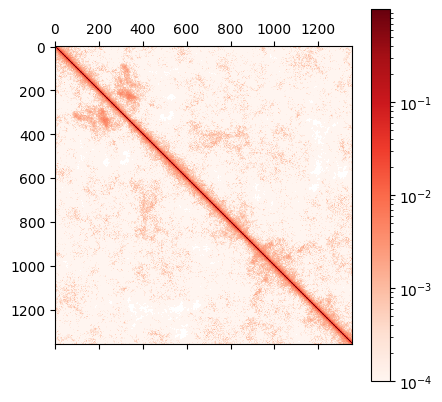

In [21]:
print("Generating the contact probability matrix...")
chr10_sim_HiC = cndbTools.traj2HiC(chr10_xyz)

# Nome do arquivo para salvar
output_file = os.path.join(output_dir, "contact_probability_matrix_CustomTypes.png")

# Gerar e salvar a imagem
plt.matshow(chr10_sim_HiC, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=chr10_sim_HiC.max()), cmap="Reds")
plt.colorbar()
plt.savefig(output_file, dpi=300, bbox_inches="tight")

print(f"Image saved successfully in {output_file}")

In the end of each replica simulation, we need to save some important values required to calculate the inversion. <br>

We are saving these files using the H5 compression because it is faster to write/read. <br>

**Note**: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [22]:
replica="1"

with h5py.File(simulation.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization.Nframes)

with h5py.File(simulation.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization.Pold)

# Specific for Types minimization
with h5py.File(simulation.folder + "/Pold_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold_type",  data=optimization.Pold_type)

with h5py.File(simulation.folder + "/PiPj_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_type",  data=optimization.PiPj_type)

The first part of the optimization is finished. Look inside the output folder to see these 4 files that will be used in next step.

In [23]:
# Set the folder name
name_folder = "iteration_0"

# Check if the folder exists
if os.path.exists(name_folder):
    # List all files in the folder
    files = [file for file in os.listdir(name_folder) if file.endswith(".h5")]
    
    # Print the found files
    if files:
        print("Found .h5 files in the folder:")
        for file in files:
            print(file)
    else:
        print("No .h5 files found in the folder.")
else:
    print(f"The folder '{name_folder}' does not exist.")

Found .h5 files in the folder:
Nframes_1.h5
PiPj_type_1.h5
Pold_1.h5
Pold_type_1.h5


The next part is the inversion. It is quite simple, just feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [24]:
inversion = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                  TypesTable='input/lambda_0.txt',
                                  mu=3.22, rc = 1.78)

iterations = "iteration_0"
replica    = "1"

with h5py.File(iterations + "/Nframes_" + replica + ".h5", 'r') as hf:
    inversion.Nframes += hf['Nframes'][()]

with h5py.File(iterations + "/Pold_" + replica + ".h5", 'r') as hf:
    inversion.Pold += hf['Pold'][:]

# For Types
with h5py.File(iterations + "/Pold_type_" + replica + ".h5", 'r') as hf:
    inversion.Pold_type += hf['Pold_type'][:]

with h5py.File(iterations + "/PiPj_type_" + replica + ".h5", 'r') as hf:
    inversion.PiPj_type += hf['PiPj_type'][:]

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 when generating $1\times10^5$ configurations among different replicas.

In [25]:
lambdas = inversion.get_lambdas_types(exp_map="input/chr10_100k_NA_neighbor.dense", 
                                      damp=3e-7)

print(lambdas)

             A1            B1
0 -1.187260e+07 -3.097162e+08
1 -3.097162e+08  1.197253e+08


Save the new lambda (`lambda_1`) and other files to analyze the inversion.

In [26]:
# Iteration
iteration = "0"

# Probabilities of As/Bs in simulation and experiment
phi_sim = inversion.calc_phi_sim_types().ravel()
phi_exp = inversion.calc_phi_exp_types().ravel()

# Save phi_sim and phi_exp data to TXT files in the 'result' folder
np.savetxt(f'result/phi_sim_CustomTypes_{iteration}.txt', phi_sim)
np.savetxt('result/phi_exp.txt', phi_exp)

# Save contact probabilities (phi_sim and phi_exp) as PNG image
plt.figure()
plt.plot(phi_sim[phi_sim > 0], 'o', label="simulation")
plt.plot(phi_exp[phi_exp > 0], 'o', label="experiment")
plt.ylabel(r'Contact probability, $\phi$')
labels_exp = ["AA", "AB", "BB"]
plt.xticks(np.arange(len(labels_exp)), labels_exp)
plt.legend()
contact_prob_png = 'result/contact_probability_CustomTypes.png'
plt.savefig(contact_prob_png, dpi=300)
plt.close()
print(f"Contact probability chart saved in: {contact_prob_png}")

# Save the simulated Hi-C in dense format in the 'result' folder
dense_sim = inversion.get_HiC_sim()
np.savetxt(f'result/hic_sim_{iteration}_CustomTypes.dense', dense_sim)

# Process experimental and simulated Hi-C data
dense_exp = np.loadtxt("input/chr10_100k.dense")
dense_exp[np.isnan(dense_exp)] = 0.0
dense_exp = normalize(dense_exp, axis=1, norm='max')

r = np.zeros(dense_sim.size).reshape(dense_sim.shape)
r = np.triu(dense_exp, k=1) + np.tril(dense_sim, k=-1) + np.diag(np.ones(len(r)))

# Save the processed matrix (combination of simulated and experimental Hi-C) as a TXT file
np.savetxt(f'result/processed_hic_{iteration}_CustomTypes.txt', r)

# Create and save the processed Hi-C as a PNG image
fig, ax = plt.subplots()  # Creating explicit figure and axis
cax = ax.matshow(r, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=dense_sim.max()), cmap="Reds")
fig.colorbar(cax)  # Adicionar barra de cores
processed_hic_png = f'result/processed_hic_{iteration}_CustomTypes.png'
plt.savefig(processed_hic_png, dpi=300)
plt.close()
print(f"Hi-C processed saved as graphic in: {processed_hic_png}")

# Save the lambda values ​​to a CSV file in the 'iteration_0' folder
lambda_folder = "iteration_0"
os.makedirs(lambda_folder, exist_ok=True)
lambdas.to_csv(f'{lambda_folder}/lambda_1.csv', index=False)

print(f"Saved files:")
print(f"- Contact probabilities (phi_sim, phi_exp) as TXT and PNG in 'result'.")
print(f"- Hi-C simulated as TXT and PNG in 'result'.")
print(f"- File lambda_1 saved in 'iteration_0'.")

Contact probability chart saved in: result/contact_probability_CustomTypes.png
Hi-C processed saved as graphic in: result/processed_hic_0_CustomTypes.png
Saved files:
- Contact probabilities (phi_sim, phi_exp) as TXT and PNG in 'result'.
- Hi-C simulated as TXT and PNG in 'result'.
- File lambda_1 saved in 'iteration_0'.


Redo these steps using the new lambda file (`lambda_1`) as input for Types potential in the next iteration. 

The tolerance can be calculate using `phi_sim_1` and `phi_exp` by the equation:<br>

$tolerance = \frac{|\phi_{sim}-\phi_{exp}|}{\phi_{exp}}$

This is appended in to file  `tolerance_and_pearson_types`.

In [27]:
# Opening and reading the contents of the file "tolerance_and_pearson_types"
file_path = "tolerance_and_pearson_types"

# Reading the file contents and displaying
with open(file_path, "r") as file:
    content = file.read()

# Displaying the content
print(content)

Tolerance: 0.284389  Pearson's Correlation: 0.592686



We included a folder named `scripts` that has some `.py` and `.slurm` files that can be used to run this optimization in parallel using slurm clusters. It is located in our github repository https://github.com/junioreif/OpenMiChroM.

## 2\# Ideal Chromosome Interaction Opmization

Following the previous section protocoal, now it is time to learn how to minimize the Ideal Chromosome (IC) interaction, the last term of our hamiltonian

<!--![](https://pubs.acs.org/cms/10.1021/acs.jpcb.1c04174/asset/images/medium/jp1c04174_m010.gif)-->

${ U }_{\text{MiChroM} }(\vec { r } )={ U }_{ HP }\left( \vec { r }  \right) +\sum _{\tiny{ \begin{matrix}  k\ge l \\ k,l \in  \text{Types} \end{matrix} } }{ { \alpha }_{ kl } } \sum _{\tiny{ \begin{matrix} i \in \{ \text{Loci of Type k}\}  \\ j \in  \{ \text{Loci of Type l} \}  \end{matrix} }} f({ r }_{ ij }) +  \sum _{ d=3 }^{ { d }_{ cutoff } }{ \gamma (d)\sum _{ i }{ f({ r }_{ i,i+d }) }  }$

The pipeline to perform the IC minimization is similar to the previous one:

1. Run a long simulation using the homopolymer + types potential + addCustomIC of the `OpenMiChroM` module. 
    The first iteration can start with all parameters equal to zero or set to an initial guess.

2. Get the frames from this simualtion to perform the inversion.

3. In the end of the inversion, new values to the interactions will be produced.

4. Calcule the tolerance between the simulated and experimental parameters. If it is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15% is enougth).

The IC file is a single column `.txt` with the values for each interaction. The file lenght should the genome distance (`d`) that you want to train. In the above equation, it goes from `d = 3` to a certain cutoff that normaly would be 200 for the human chromosome. <br> 

Lets create the initial file with this format:
<pre><code>
0
0
.
.
.
0
</pre></code>

Save it as `lambda_0`.

In [28]:
# Caminho do arquivo
file_path = "input/lambda_IC_0.txt"

init = 0
end = 1356  # Last line filled with 0 will be 1356

# Check if the file already exists
if not os.path.exists(file_path):
    # Open the file for writing
    with open(file_path, "w") as file:
        # Write 1356 lines with the value 0
        for i in range(init, end):  # range(0, 1356) generates from 0 to 1355 (1356 rows in total)
            if i + 1 < end :
                file.write("0")
                file.write("\n")
            else:
                file.write("0")

    print(f"File '{file_path}' created with {end} lines containing the value 0.")
else:
    print(f"The file '{file_path}' already exists. No action has been taken.")

File 'input/lambda_IC_0.txt' created with 1356 lines containing the value 0.


Again, create the simulation that will colapse the initial structure.

In [29]:
simulation_ic = MiChroM(name='opt_ic_chr10_100K', temperature=1.0, timeStep=0.01)

simulation_ic.setup(platform="CUDA")
simulation_ic.saveFolder('iteration_ic_0')
mychro_ic = simulation_ic.createRandomWalk(ChromSeq="input/seq_chr10_100k.txt")
simulation_ic.loadStructure(mychro_ic, center=True)

# Adding Potentials section

# **Homopolymer Potentials**  
simulation_ic.addFENEBonds(kFb=30.0)
simulation_ic.addAngles(kA=2.0)
simulation_ic.addRepulsiveSoftCore(eCut=4.0)

# **Chromosome Potentials**
simulation_ic.addTypetoType()
simulation_ic.addCustomIC(IClist="input/lambda_IC_0.txt",
                          dinit=3, dend=200) 

# The restriction term for colapsing the beads
simulation_ic.addFlatBottomHarmonic(kR=5*10**-3, nRad=8.0)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.1.0 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             

         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is des

Execute the simulation to colapse the initial structure

In [30]:
collapse_ic = 4*10**5
simulation_ic.createSimulation()
simulation_ic.run(nsteps=collapse_ic, report=False)

FENEBond was added
AngleForce was added
RepulsiveSoftCore was added
TypetoType was added
CustomIC was added
FlatBottomHarmonic was added
Setting positions... loaded!
Setting velocities... loaded!
Context created!

Simulation name: opt_ic_chr10_100K
Number of beads: 1356, Number of chains: 1
Potential energy: 27.74789, Kinetic Energy: 1.50231 at temperature: 1.0

Potential energy per forceGroup:
                                 Values
FENEBond                  28235.218887
AngleForce                 2775.337441
RepulsiveSoftCore          8833.815921
TypetoType                -2395.396790
CustomIC                      0.000000
FlatBottomHarmonic          177.165899
Potential Energy (total)  37626.141357


It is time to remove the flat bottom constraint and include the spherical confinement mimicking the nuclear density. 

In [31]:
# Remove Flat initialized in Collapse
simulation_ic.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation_ic.addAdditionalForce(simulation_ic.addSphericalConfinementLJ, radius="density", density=0.1)

Removed FlatBottomHarmonic from the system!
adding force  SphericalConfinementLJ 5


And create the IC optimization object.

In [32]:
optimization_ic = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                        TypesTable='input/lambda_0.txt',
                                        IClist="input/lambda_IC_0.txt",
                                        dinit=3, dend=200)

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from a certain amount of different replicas. For example, $20$ replicas with $5.000$ saved frames from each. <br> 

This can take some time, so in this tutorial we will use just 1 replica. <br>

In [33]:
block    = 1*10**3
n_blocks = 5*10**3

simulation_ic.createReporters(statistics=True, traj=True, trajFormat="cndb", energyComponents=True, interval=1000)
simulation_ic.createReporters(statistics=True, traj=True, trajFormat="gro", energyComponents=True, interval=1000)

for _ in range(n_blocks):
    # perform 1 block of simulation
    simulation_ic.run(nsteps=block, report=False)
    
    # feed the optimization with the last chromosome configuration
    optimization_ic.prob_calculation_IC(simulation_ic.getPositions())


In [34]:
compile('opt_ic_chr10_100K_0_state', 'all_frame_simulation.gro', 'iteration_ic_0')

In [35]:
chr10_traj_ic = cndbTools.load(filename='iteration_ic_0/opt_ic_chr10_100K_0.cndb')
first_frame = min([int(key) for key in chr10_traj_ic.cndb.keys() if key != 'types'])
last_frame = max([int(key) for key in chr10_traj_ic.cndb.keys() if key != 'types'])

# Calculando Radius of Gyration
chr10_xyz_ic = cndbTools.xyz(frames=[first_frame, last_frame, 1], XYZ=[0, 1, 2])
chr10_RG_ic = cndbTools.compute_RG(chr10_xyz_ic)

# Salvando os dados em um arquivo na pasta 'resultado'
output_file_txt = os.path.join(output_dir, 'chr10_RG_ic.txt')
with open(output_file_txt, 'w') as f:
    for rg_value in chr10_RG_ic:
        f.write(f"{rg_value}\n")

print(f"Dados salvos em {output_file_txt}")

# Criando e salvando o gráfico com os dados de chr10_RG_ic
plt.figure()  # Inicia uma nova figura para garantir que não haja interferências anteriores
plt.plot(chr10_RG_ic, linestyle='-', color='blue')  # Usa chr10_RG_ic diretamente
plt.ylabel(r'Radius of Gyration ($\sigma$)', fontsize=11)
plt.xlabel(r'Simulation Frames', fontsize=11)
plt.title('Radius of Gyration Over Simulation Frames')
output_file_img = os.path.join(output_dir, 'chr10_RG_plot_ic.png')
plt.savefig(output_file_img, dpi=300)
plt.close()

print(f"Gráfico salvo em {output_file_img}")

Dados salvos em result\chr10_RG_ic.txt
Gráfico salvo em result\chr10_RG_plot_ic.png


Generating the contact probability matrix...
Reading frame 0 of 4999
Reading frame 500 of 4999
Reading frame 1000 of 4999
Reading frame 1500 of 4999
Reading frame 2000 of 4999
Reading frame 2500 of 4999
Reading frame 3000 of 4999
Reading frame 3500 of 4999
Reading frame 4000 of 4999
Reading frame 4500 of 4999
Image saved successfully in result\contact_probability_matrix_ic.png


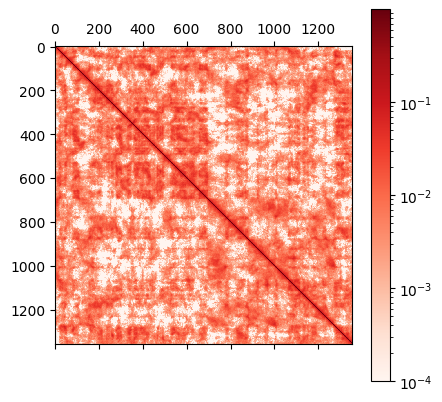

In [36]:
print("Generating the contact probability matrix...")
chr10_sim_HiC_ic = cndbTools.traj2HiC(chr10_xyz_ic)

# Nome do arquivo para salvar
output_file = os.path.join(output_dir, "contact_probability_matrix_ic.png")

# Gerar e salvar a imagem
plt.matshow(chr10_sim_HiC_ic, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=chr10_sim_HiC_ic.max()), cmap="Reds")
plt.colorbar()
plt.savefig(output_file, dpi=300, bbox_inches="tight")

print(f"Image saved successfully in {output_file}")

It is time to save the important files required for the inversion. <br>

These files are prefered to be saved using the H5 compression. <br>

**Note**: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [37]:
replica="1"

with h5py.File(simulation_ic.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization_ic.Nframes)

with h5py.File(simulation_ic.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization_ic.Pold)

# Specific for IC minimization
with h5py.File(simulation_ic.folder + "/PiPj_IC_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_IC",  data=optimization_ic.PiPj_IC)

In [38]:
# Set the folder name
name_folder = "iteration_ic_0"

# Check if the folder exists
if os.path.exists(name_folder):
    # List all files in the folder
    files = [file for file in os.listdir(name_folder) if file.endswith(".h5")]
    
    # Print the found files
    if files:
        print("Found .h5 files in the folder:")
        for file in files:
            print(file)
    else:
        print("No .h5 files found in the folder.")
else:
    print(f"The folder '{name_folder}' does not exist.")

Found .h5 files in the folder:
Nframes_1.h5
PiPj_IC_1.h5
Pold_1.h5


The next part is the inversion. We need to feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [39]:
inversion_ic = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt",
                                     TypesTable='input/lambda_0.txt',
                                     IClist="input/lambda_IC_0.txt",    
                                     dinit=3, dend=200)

In [40]:
iterations = "iteration_ic_0"
replica    = "1"

with h5py.File(iterations + "/Nframes_" + replica + ".h5", 'r') as hf:
    inversion_ic.Nframes += hf['Nframes'][()]

with h5py.File(iterations + "/Pold_" + replica + ".h5", 'r') as hf:
    inversion_ic.Pold += hf['Pold'][:]

# For IC
with h5py.File(iterations + "/PiPj_IC_" + replica + ".h5", 'r') as hf:
    inversion_ic.PiPj_IC += hf['PiPj_IC'][:]

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 when generating $1\times10^5$ configurations among different replicas.

In [41]:
lambdas_ic = inversion_ic.get_lambdas_IC(exp_map="input/chr10_100k_NA_neighbor.dense", damp=5e-4)

lambdas_ic.size, lambdas_ic[:5]

(197,
 array([-1.63863465e+08,  7.88124831e+08, -1.10417584e+08,  1.50540082e+09,
         9.44999491e+08]))

Save the new lambda (`lambda_1_ic`) and other files to analyze the inversion.

In [42]:
# Set the output folder
output_dir = "result"
os.makedirs(output_dir, exist_ok=True)  # Ensures the folder exists

iteration = "0"

# Probabilities of As/Bs in the simulation and experiment
phi_sim = inversion_ic.calc_phi_sim_IC()
phi_exp = inversion_ic.calc_phi_exp_IC()

np.savetxt(f"{output_dir}/phi_sim_ic_{iteration}.txt", phi_sim)
np.savetxt(f"{output_dir}/phi_exp_ic.txt", phi_exp)

# Create the first graph (contact probability)
plt.figure()
plt.plot(phi_sim, label="simulation")
plt.plot(phi_exp, label="experiment")
plt.ylabel(r'Contact probability, $\phi$')
plt.xlabel(r'Genomic distance, $d$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig(f"{output_dir}/contact_probability_plot_ic.png", dpi=300, bbox_inches="tight")  # Save the chart
plt.close()  # Close the figure to avoid overlapping

# Save and plot the simulated Hi-C
dense_sim = inversion_ic.get_HiC_sim()
np.savetxt(f"{output_dir}/hic_sim_{iteration}_ic.dense", dense_sim)

dense_exp = np.loadtxt(filename)
dense_exp[np.isnan(dense_exp)] = 0.0
dense_exp = normalize(dense_exp, axis=1, norm='max')
r = np.zeros(dense_sim.size).reshape(dense_sim.shape)
r = np.triu(dense_exp, k=1) + np.tril(dense_sim, k=-1) + np.diag(np.ones(len(r)))

# Create the second chart (Hi-C)
plt.figure()
plt.matshow(r, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=dense_sim.max()), cmap="Reds")
plt.colorbar()
plt.savefig(f"{output_dir}/hic_plot_ic.png", dpi=300, bbox_inches="tight")  # Save the chart
plt.close()  # Close the figure to avoid overlapping

# Save the new lambda file
np.savetxt(f"{output_dir}/lambda_1_ic.txt", lambdas_ic)

<Figure size 640x480 with 0 Axes>

The simulated interaction terms (`lambdas_1` data) can be used to fit a model in order to run production simulations with longer cutoffs in the IC energy term. The resulting model is used in the `addCustomIC` method of the `OpenMiChroM` class.

In [43]:
# Create output folder if it does not exist
output_dir = "result"
os.makedirs(output_dir, exist_ok=True)

# Define the objective function
def objective1(x, a, b, c):
    return -a / np.log(x) - b / x**2 - c / x

# Generate the data
y = lambdas_ic
x = np.arange(3, lambdas_ic.size + 3)

# Create the scatter plot
plt.figure()
plt.scatter(x, y, label='simulation')

# Curve Fitting
popt, pcov = curve_fit(objective1, x, y)
a, b, c = popt
standard_dev = np.sqrt(np.diag(pcov))

# Display the adjusted parameters
print(popt, standard_dev)

# Generate fitted curve
x_fit = x
y_fit = objective1(x_fit, a, b, c)

plt.plot(x_fit, y_fit, label='fitting', color='#ff7f0e')

# Adjust labels and legend
plt.xlabel("Genomic distance, $d$")
plt.ylabel("Lambda values")
plt.legend()

# Save the graph in the result folder
output_file = os.path.join(output_dir, "curve_fitting_plot_ic.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")
plt.close()  # Close the figure to avoid overlapping

print(f"Graph saved successfully at {output_file}")

C:\Users\joao_vitor\AppData\Local\Temp\ipykernel_28452\3959230161.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(objective1, x, y)


[117.29163331   1.           1.        ] [inf inf inf]
Graph saved successfully at result\curve_fitting_plot_ic.png


Nice job! You have completed the optimization tutorial of the MiChroM energy terms. 